# Point72 Global Futures Analysis Cumulative Returns

Diego Alvarez <br> diego.alvarez@colorado.edu

# Packages

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Read in Data

In [2]:
parent_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
data_path = os.path.join(parent_path, "data")
price_path = os.path.join(data_path, "prices.parquet")

In [3]:
df_raw = pd.read_parquet(
    path = price_path,
    engine = "pyarrow")

# Roll Adjustment

It doesn't say to do or not account for role adjustment so in this case both will be used. Just use close price. Since there is already a method for it in MarketStats.py, just use that and set ```verbose==True``` to find where the attribute is saved.

Access object

In [4]:
import sys
src_path = os.path.join(parent_path, "src")
sys.path.append(src_path)

from MarketStats import MarketStats
market_stats = MarketStats(price_path, verbose = True)

In [5]:
market_stats.get_roll_adjusted_close()

Roll Adjusted closed saved as attribute df_roll_adj


In [6]:
df_roll_adj = market_stats.df_roll_adj

# Calculating Cumulative Return

In [7]:
df_nyc_input = (df_roll_adj.merge(
    right = df_raw[["local_time", "nyc_time"]],
    how = "inner",
    on = ["local_time"]).
    drop(columns = ["local_time"]))

In [8]:
df_london_nyc = (df_raw.query(
    "zone == 'London'")
    [["local_time", "nyc_time"]].
    rename(columns = {"local_time": "london_time"}))

df_london_map = (df_raw[
    ["nyc_time", "local_time"]].
    merge(right = df_london_nyc, how = "inner", on = ["nyc_time"]).
    drop(columns = ["nyc_time"]))

df_london_input = (df_roll_adj.merge(
    right = df_london_map, how = "inner", on = ["local_time"]).
    drop(columns = ["local_time"]))

In [9]:
def get_cum_rtn(df_input: pd.DataFrame, col_name: str, hour1: int = 9, hour2: int = 12):
    
    df_longer = (df_input.assign(
        hour = lambda x: x[col_name].dt.hour).
        query("hour >= @hour1 & hour <= @hour2").
        drop(columns = ["hour"]).
        groupby(["contract_name", col_name]).
        head(1))
    
    df_wider = (df_longer.melt(
        id_vars = [col_name, "contract_name"], var_name = "roll").
        pivot(index = col_name, columns = ["contract_name", "roll"], values = "value"))
    
    df_cum_longer = (np.cumprod((1 + df_wider.pct_change().dropna())) - 1).reset_index().melt(id_vars = [col_name])
    
    return df_cum_longer

## 10y Cum Returns 2y Lookback Window

In [10]:
df_nyc_cum_rtn = get_cum_rtn(df_nyc_input, "nyc_time")
df_london_cum_rtn = get_cum_rtn(df_london_input, "london_time", hour1 = 8, hour2 = 11)

In [11]:
max_year = df_nyc_cum_rtn.nyc_time.max().date().year
min_year = max_year - 2

In [12]:
df_nyc_cum_rtn = (df_nyc_cum_rtn.assign(
    year = lambda x: x.nyc_time.dt.year).
    query("year >= @min_year").
    drop(columns = ["year"]))

df_london_cum_rtn = (df_london_cum_rtn.assign(
    year = lambda x: x.london_time.dt.year).
    query("year >= @min_year").
    drop(columns = ["year"]))

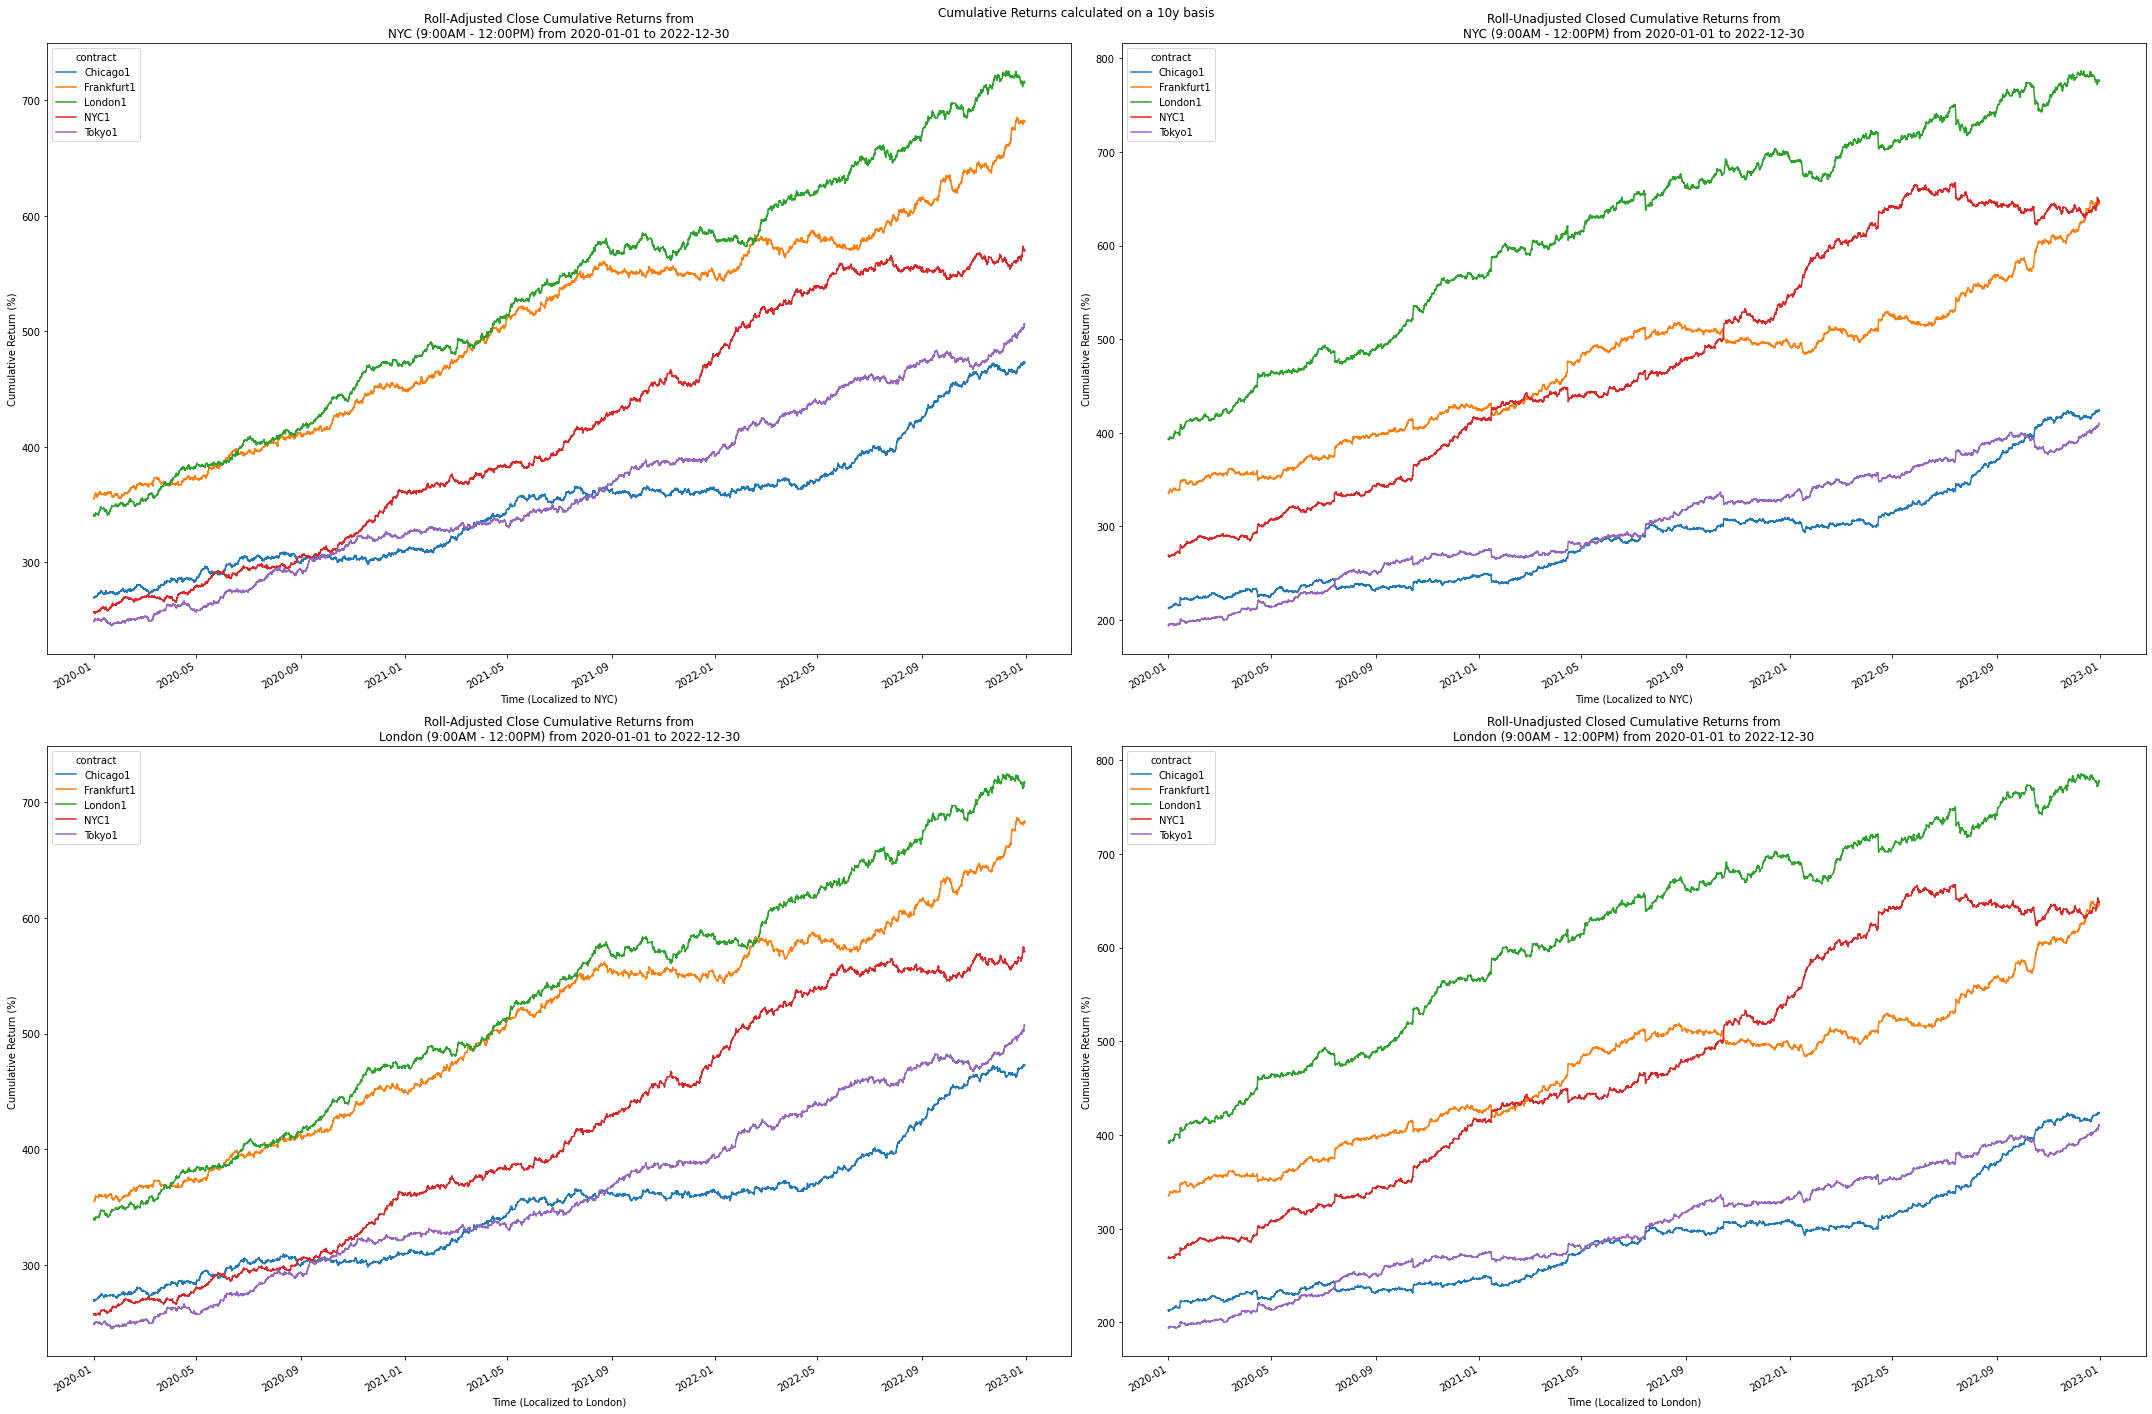

In [13]:
rolls = ["adj", "unadj"]
roll_renamer = {"adj": "Roll-Adjusted Close", "unadj": "Roll-Unadjusted Closed"}
fig, axes = plt.subplots(ncols = len(rolls), nrows = 2, figsize = (30,20))

for i, roll in enumerate(rolls):
    
    (df_nyc_cum_rtn.assign(
        value = lambda x: x.value * 100).
        query("roll == @roll").
        drop(columns = ["roll"]).
        rename(columns = {"contract_name": "contract"}).
        pivot(index = "nyc_time", columns = "contract", values = "value").
        plot(
            ax = axes[0,i],
            xlabel = "Time (Localized to NYC)",
            ylabel = "Cumulative Return (%)",
            title = "{} Cumulative Returns from\nNYC (9:00AM - 12:00PM) from {} to {}".format(
                roll_renamer[roll],
                df_nyc_cum_rtn.nyc_time.min().date(),
                df_nyc_cum_rtn.nyc_time.max().date())))
    
    (df_london_cum_rtn.assign(
        value = lambda x: x.value * 100).
        query("roll == @roll").
        drop(columns = ["roll"]).
        rename(columns = {"contract_name": "contract"}).
        pivot(index = "london_time", columns = "contract", values = "value").
        plot(
            ax = axes[1,i],
            xlabel = "Time (Localized to London)",
            ylabel = "Cumulative Return (%)",
            title = "{} Cumulative Returns from\nLondon (8:00AM - 11:00AM) from {} to {}".format(
                roll_renamer[roll],
                df_london_cum_rtn.london_time.min().date(),
                df_london_cum_rtn.london_time.max().date())))
    
fig.suptitle("Cumulative Returns calculated on a 10y basis")
plt.tight_layout()
plt.show()

## 2y Cum Returns 2y Lookback Window

In [14]:
df_nyc_input = (df_nyc_input.assign(
    year = lambda x: x.nyc_time.dt.year).
    query("year >= @min_year").
    drop(columns = ["year"]))

df_london_input = (df_london_input.assign(
    year = lambda x: x.london_time.dt.year).
    query("year >= @min_year").
    drop(columns = ["year"]))

In [15]:
df_nyc_cum_rtn = get_cum_rtn(df_nyc_input, "nyc_time")
df_london_cum_rtn = get_cum_rtn(df_london_input, "london_time", )

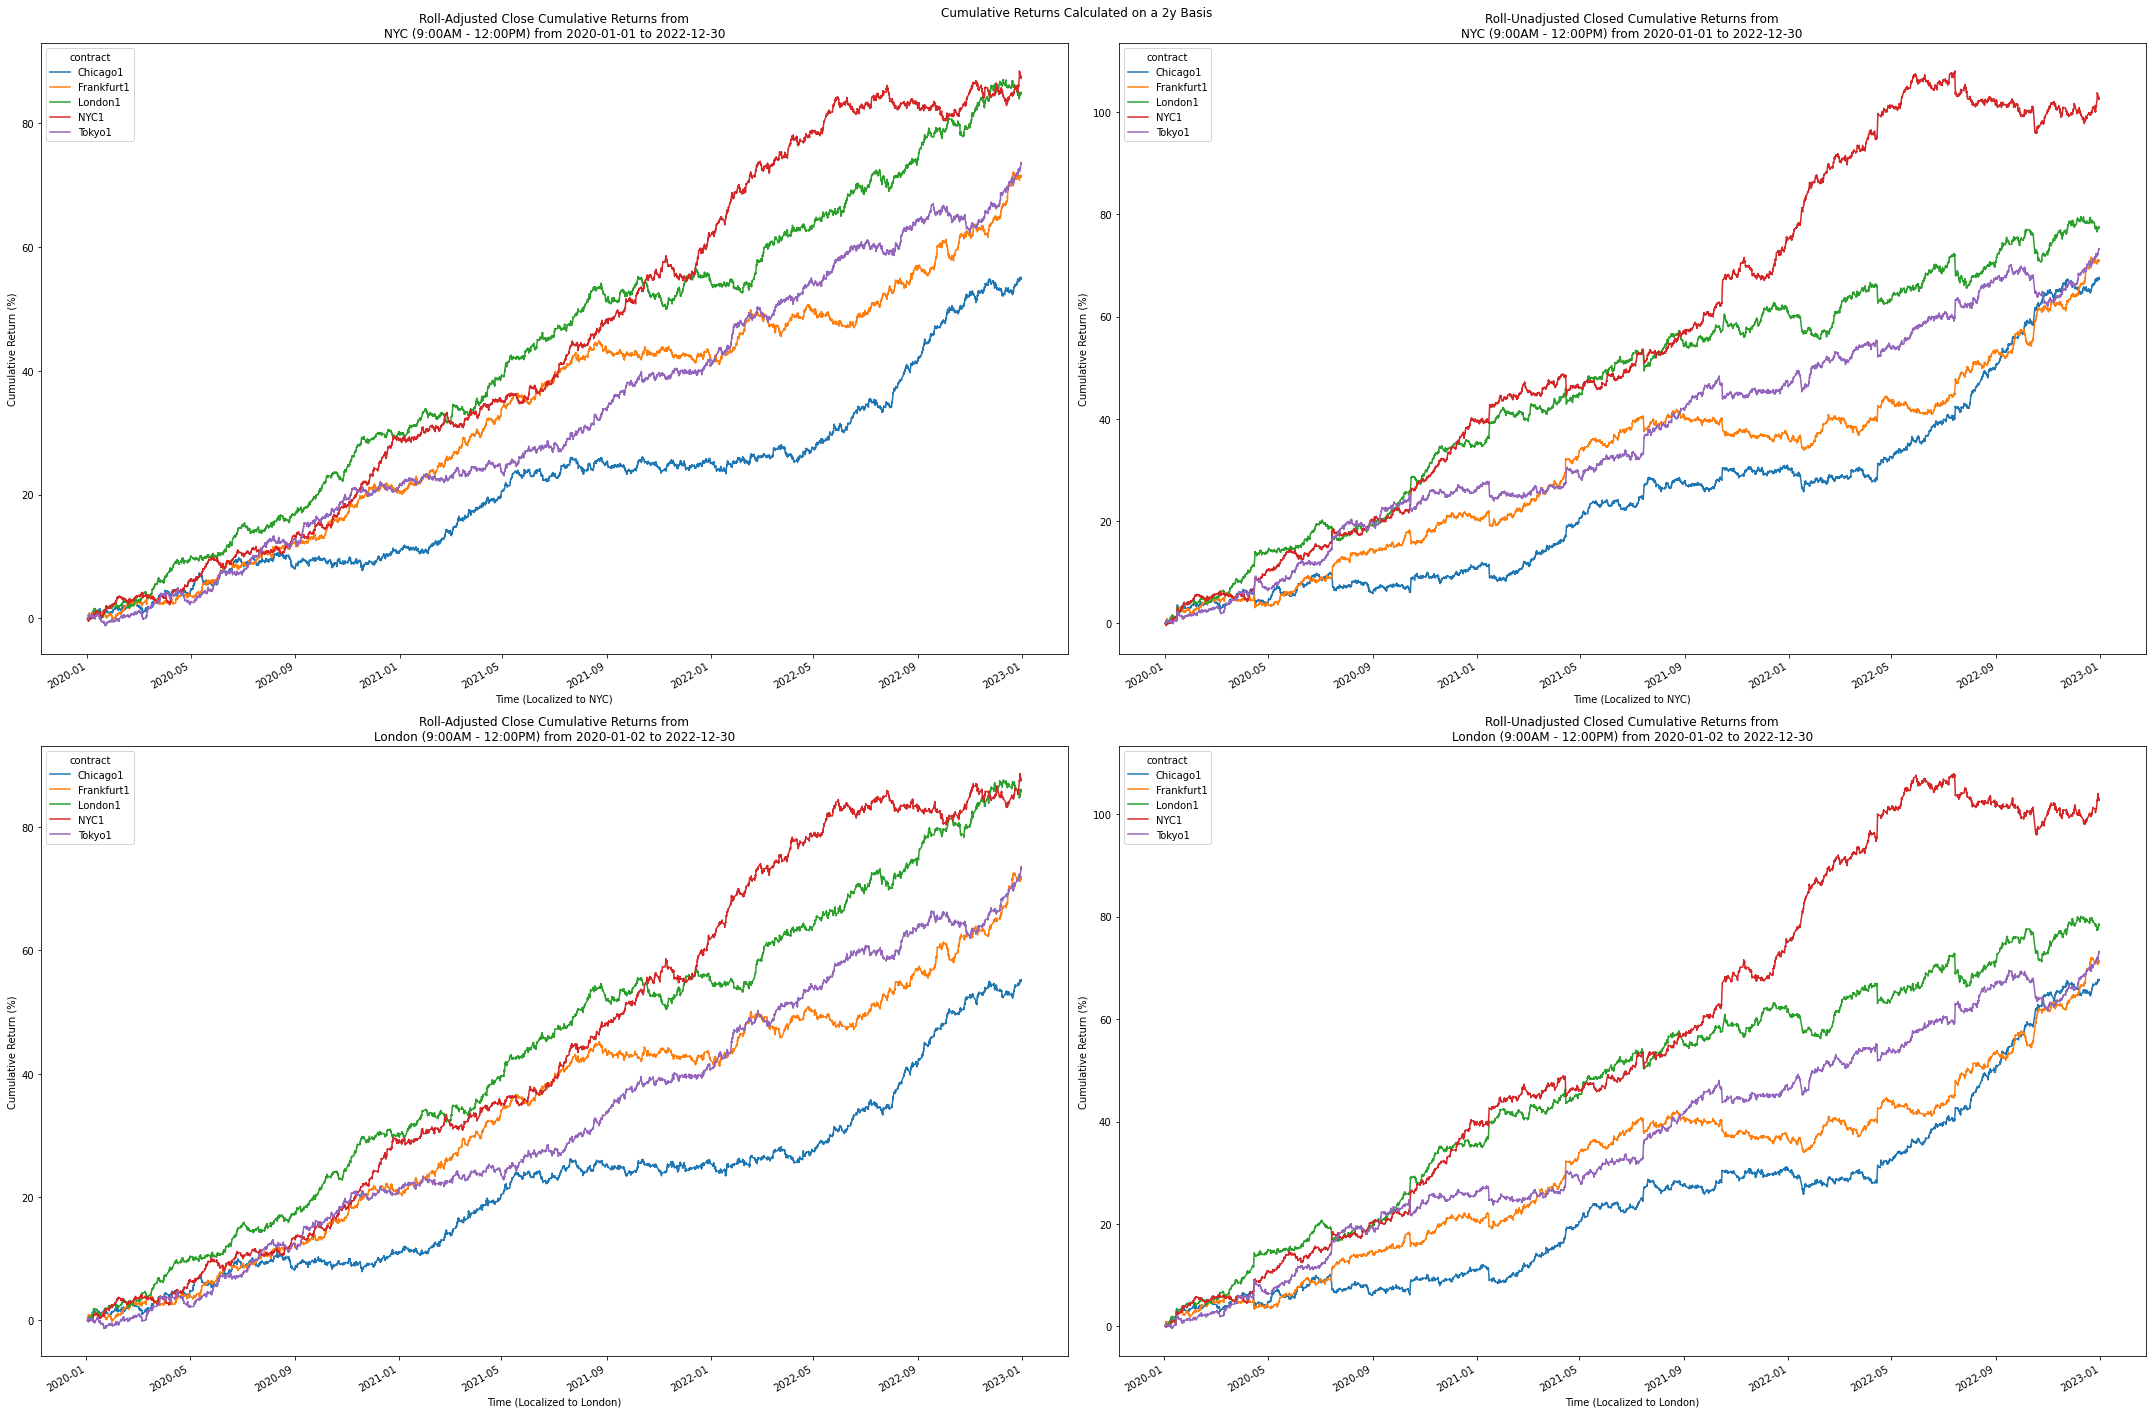

In [16]:
rolls = ["adj", "unadj"]
roll_renamer = {"adj": "Roll-Adjusted Close", "unadj": "Roll-Unadjusted Closed"}
fig, axes = plt.subplots(ncols = len(rolls), nrows = 2, figsize = (30,20))

for i, roll in enumerate(rolls):
    
    (df_nyc_cum_rtn.assign(
        value = lambda x: x.value * 100).
        query("roll == @roll").
        drop(columns = ["roll"]).
        rename(columns = {"contract_name": "contract"}).
        pivot(index = "nyc_time", columns = "contract", values = "value").
        plot(
            ax = axes[0,i],
            xlabel = "Time (Localized to NYC)",
            ylabel = "Cumulative Return (%)",
            title = "{} Cumulative Returns from\nNYC (9:00AM - 12:00PM) from {} to {}".format(
                roll_renamer[roll],
                df_nyc_cum_rtn.nyc_time.min().date(),
                df_nyc_cum_rtn.nyc_time.max().date())))
    
    (df_london_cum_rtn.assign(
        value = lambda x: x.value * 100).
        query("roll == @roll").
        drop(columns = ["roll"]).
        rename(columns = {"contract_name": "contract"}).
        pivot(index = "london_time", columns = "contract", values = "value").
        plot(
            ax = axes[1,i],
            xlabel = "Time (Localized to London)",
            ylabel = "Cumulative Return (%)",
            title = "{} Cumulative Returns from\nLondon (8:00AM - 11:00AM) from {} to {}".format(
                roll_renamer[roll],
                df_london_cum_rtn.london_time.min().date(),
                df_london_cum_rtn.london_time.max().date())))
    
fig.suptitle("Cumulative Returns Calculated on a 2y Basis")
plt.tight_layout()
plt.show()

# Cumulative Buy and Sell Volume

In [22]:
df_vol_wider = (df_raw[
    ["contract_name", "nyc_time", "buy_vol", "sell_vol"]].
    assign(hour = lambda x: x.nyc_time.dt.hour).
    query("hour >= 9 & hour <= 12").
    drop(columns = ["hour"]).
    melt(id_vars = ["contract_name", "nyc_time"]).
    pivot(index = ["nyc_time"], columns = ["contract_name", "variable"], values = "value").
    fillna(0))

df_cum_vol = np.cumsum(df_vol_wider)
df_cum_vol_longer = df_cum_vol.reset_index().melt(id_vars = ["nyc_time"])